In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Activation, LeakyReLU
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from skimage.transform import pyramid_expand
from Subpixel import Subpixel

In [14]:
x_train = np.load(r'C:\Project\celeba-dataset\processed\x_train\x_train.npy')
x_val = np.load(r'C:\Project\celeba-dataset\processed\x_val\x_val.npy')
y_train = np.load(r'C:\Project\celeba-dataset\processed\y_train\y_train.npy')
y_val = np.load(r'C:\Project\celeba-dataset\processed\y_val\y_val.npy')

print(x_train.shape, y_train.shape) # (300, 44, 44, 3) (300, 176, 176, 3)
print(x_val.shape, y_val.shape) # (300, 44, 44, 3) (300, 176, 176, 3)

(300, 44, 44, 3) (300, 176, 176, 3)
(300, 44, 44, 3) (300, 176, 176, 3)


(44, 44, 3) (44, 44, 3)


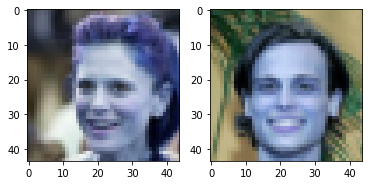

In [16]:
x1 = x_train[1] 
x2 = x_val[1]

print(x1.shape, x2.shape) # (44, 44, 3) (44, 44, 3)

plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.show()

In [6]:
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))
a = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
a = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(a)
a = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(a)
a = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')(a)
a = Subpixel(filters=3, kernel_size=3, r=upscale_factor, padding='same')(a) # r = upscale_factor : (44, 44, 3) -> (176, 176, 3)
outputs = LeakyReLU(alpha=0.1)(a)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 44, 44, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 16)        4624      
_________________________________________________________________
subpixel (Subpixel)          (None, 176, 176, 3)       6960      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 176, 176, 3)      

In [10]:
cp = ModelCheckpoint('../project/celeba-dataset/models/model-final.h5', monitor='val_loss', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=40, verbose=1, mode='auto')
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1, mode='auto')

model.compile(loss='mse', optimizer='adam', metrics=['mae']) # loss='mse'-> 이미지가 얼마나 같은지, 픽셀 값이 얼마나 같은지 확인하기 위해서 mse사용
history = model.fit(x_train, y_train, epochs=10, validation_data=[x_val, y_val], verbose=1, callbacks=[cp])

loss = history.history['loss']
mae = history.history['mae']

print("loss : ", loss[-1])  
print("mae : ", mae[-1])


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.0850 - mae: 0.2488
Epoch 00001: val_loss improved from inf to 0.00000, saving model to ../project/celeba-dataset/models\model-final.h5
10/10 [==============================] - 1s 56ms/step - loss: 0.0850 - mae: 0.2488 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.0852 - mae: 0.2475
Epoch 00002: val_loss did not improve from 0.00000
10/10 [==============================] - 0s 23ms/step - loss: 0.0852 - mae: 0.2475 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.0852 - mae: 0.2507
Epoch 00003: val_loss did not improve from 0.00000
10/10 [==============================] - 0s 23ms/step - loss: 0.0852 - mae: 0.2507 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.0836 - mae: 0.2473
Epoch 00004: val_loss did not improve from

In [3]:
plt.figure(figsize=(10, 6)) # (10, 6) 의 면적을 잡음

plt.subplot(2, 1, 1)    # 2행 1열중 첫번째
plt.plot(history.history['loss'], marker='.', c='red', label='loss')
plt.plot(history.history['val_loss'], marker='.', c='blue', label='val_loss')
plt.grid()

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)    # 2행 1열중 첫번째
plt.plot(history.history['mae'], marker='.', c='red', label='loss')
plt.plot(history.history['val_mae'], marker='.', c='blue', label='val_mae')
plt.grid()

plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(loc='upper right')

NameError: name 'history' is not defined

In [13]:
x_test = np.load(r'C:\Project\celeba-dataset\processed\x_test\x_test.npy')
y_test = np.load(r'C:\Project\celeba-dataset\processed\y_test\y_test.npy')

print(x_test.shape, y_test.shape)

(300, 44, 44, 3) (300, 176, 176, 3)


In [19]:

from skimage.transform import pyramid_expand

test_idx = 10

# 저해상도 이미지(input)
x1_test = x_test[test_idx]

# 저해상도 이미지 확대시킨 이미지
x1_test_resized = pyramid_expand(x1_test, 4, multichannel=True) # multichannel=True -> 컬러채널 허용

# 모델이 예측한 이미지(output)
y_pred = model.predict(x1_test.reshape((1, 44, 44, 3)))

# 정답 이미지
y1_test = y_test[test_idx]

print(x1_test.shape, y1_test.shape) # (44, 44, 3) (176, 176, 3)

NameError: name 'model' is not defined